# AITA Toxicity Analysis

## Prepare Environment

In [26]:
from tqdm import tqdm
import json
from transformers import pipeline
import matplotlib.pyplot as plt
import re

In [21]:
# log into huggingface to load models and datasets

from huggingface_hub import login
login()

## Load Toxigen RoBERTa Model

In [22]:
# load toxigen roberta model
toxigen_roberta = pipeline("text-classification", model="tomh/toxigen_roberta", truncation=True, device_map='cuda')

# LABEL 0 = NON-TOXIC
# LABEL 1 = TOXIC

## Load Generation Results then Evaluate Toxicity of Predictions and References Using Toxigen RoBERTa

In [40]:
# (Geneeration Results File, Toxicity Analysis Folder, Model Name, Dataset Name)
generation_result_pairs = [
    # Fine-tuned
    #  Flan-T5 XL
    ('AITA_Finetuned_Evaluations\\flan-t5-xl\\binary\generation_results.json', 'AITA_Finetuned_Evaluations\\flan-t5-xl\\binary\Toxicity_Analysis', 'Flan-T5-XL', 'Reddit-AITA-Binary'),
    ('AITA_Finetuned_Evaluations\\flan-t5-xl\\binary-top-2k\generation_results.json', 'AITA_Finetuned_Evaluations\\flan-t5-xl\\binary-top-2k\Toxicity_Analysis', 'Flan-T5-XL', 'Reddit-AITA-Binary-Top-2k'),
    ('AITA_Finetuned_Evaluations\\flan-t5-xl\multiclass\generation_results.json', 'AITA_Finetuned_Evaluations\\flan-t5-xl\multiclass\Toxicity_Analysis', 'Flan-T5-XL', 'Reddit-AITA-Multiclass'),
    ('AITA_Finetuned_Evaluations\\flan-t5-xl\multiclass-top-2k\generation_results.json', 'AITA_Finetuned_Evaluations\\flan-t5-xl\multiclass-top-2k\Toxicity_Analysis', 'Flan-T5-XL', 'Reddit-AITA-Multiclass-Top-2k'),
    # Flan-T5 XXL
    ('AITA_Finetuned_Evaluations\\flan-t5-xxl\\binary\generation_results.json', 'AITA_Finetuned_Evaluations\\flan-t5-xxl\\binary\Toxicity_Analysis', 'Flan-T5-XXL', 'Reddit-AITA-Binary'),
    ('AITA_Finetuned_Evaluations\\flan-t5-xxl\\binary-top-2k\generation_results.json', 'AITA_Finetuned_Evaluations\\flan-t5-xxl\\binary-top-2k\Toxicity_Analysis', 'Flan-T5-XXL', 'Reddit-AITA-Binary-Top-2k'),
    ('AITA_Finetuned_Evaluations\\flan-t5-xxl\multiclass\generation_results.json', 'AITA_Finetuned_Evaluations\\flan-t5-xxl\multiclass\Toxicity_Analysis', 'Flan-T5-XXL', 'Reddit-AITA-Multiclass'),
    ('AITA_Finetuned_Evaluations\\flan-t5-xxl\multiclass-top-2k\generation_results.json', 'AITA_Finetuned_Evaluations\\flan-t5-xxl\multiclass-top-2k\Toxicity_Analysis', 'Flan-T5-XXL', 'Reddit-AITA-Multiclass-Top-2k'),
    # llama2-7b-chat
    ('AITA_Finetuned_Evaluations\llama2-7b-chat\\binary\generation_results.json', 'AITA_Finetuned_Evaluations\llama2-7b-chat\\binary\Toxicity_Analysis', 'Llama2-7B-Chat', 'Reddit-AITA-Binary'),
    ('AITA_Finetuned_Evaluations\llama2-7b-chat\\binary-top-2k\generation_results.json', 'AITA_Finetuned_Evaluations\llama2-7b-chat\\binary-top-2k\Toxicity_Analysis', 'Llama2-7B-Chat', 'Reddit-AITA-Binary-Top-2k'),
    ('AITA_Finetuned_Evaluations\llama2-7b-chat\multiclass\generation_results.json', 'AITA_Finetuned_Evaluations\llama2-7b-chat\multiclass\Toxicity_Analysis', 'Llama2-7B-Chat', 'Reddit-AITA-Multiclass'),
    ('AITA_Finetuned_Evaluations\llama2-7b-chat\multiclass-top-2k\generation_results.json', 'AITA_Finetuned_Evaluations\llama2-7b-chat\multiclass-top-2k\Toxicity_Analysis', 'Llama2-7B-Chat', 'Reddit-AITA-Multiclass-Top-2k'),
    # llama2-13b-chat
    ('AITA_Finetuned_Evaluations\llama2-13b-chat\\binary\generation_results.json', 'AITA_Finetuned_Evaluations\llama2-13b-chat\\binary\Toxicity_Analysis', 'Llama2-13B-Chat', 'Reddit-AITA-Binary'),
    ('AITA_Finetuned_Evaluations\llama2-13b-chat\\binary-top-2k\generation_results.json', 'AITA_Finetuned_Evaluations\llama2-13b-chat\\binary-top-2k\Toxicity_Analysis', 'Llama2-13B-Chat', 'Reddit-AITA-Binary-Top-2k'),
    ('AITA_Finetuned_Evaluations\llama2-13b-chat\multiclass\generation_results.json', 'AITA_Finetuned_Evaluations\llama2-13b-chat\multiclass\Toxicity_Analysis', 'Llama2-13B-Chat', 'Reddit-AITA-Multiclass'),
    ('AITA_Finetuned_Evaluations\llama2-13b-chat\multiclass-top-2k\generation_results.json', 'AITA_Finetuned_Evaluations\llama2-13b-chat\multiclass-top-2k\Toxicity_Analysis', 'Llama2-13B-Chat', 'Reddit-AITA-Multiclass-Top-2k'),
    # Zero-shot
    # Flan-T5 XL
    ('AITA_ZeroShot_Evaluations\\flan-t5-xl\\binary\generation_results.json', 'AITA_ZeroShot_Evaluations\\flan-t5-xl\\binary\Toxicity_Analysis', 'Flan-T5-XL', 'Reddit-AITA-Binary'),
    ('AITA_ZeroShot_Evaluations\\flan-t5-xl\\binary-top-2k\generation_results.json', 'AITA_ZeroShot_Evaluations\\flan-t5-xl\\binary-top-2k\Toxicity_Analysis', 'Flan-T5-XL', 'Reddit-AITA-Binary-Top-2k'),
    ('AITA_ZeroShot_Evaluations\\flan-t5-xl\multiclass\generation_results.json', 'AITA_ZeroShot_Evaluations\\flan-t5-xl\multiclass\Toxicity_Analysis', 'Flan-T5-XL', 'Reddit-AITA-Multiclass'),
    ('AITA_ZeroShot_Evaluations\\flan-t5-xl\multiclass-top-2k\generation_results.json', 'AITA_ZeroShot_Evaluations\\flan-t5-xl\multiclass-top-2k\Toxicity_Analysis', 'Flan-T5-XL', 'Reddit-AITA-Multiclass-Top-2k'),
    # Flan-T5 XXL
    ('AITA_ZeroShot_Evaluations\\flan-t5-xxl\\binary\generation_results.json', 'AITA_ZeroShot_Evaluations\\flan-t5-xxl\\binary\Toxicity_Analysis', 'Flan-T5-XXL', 'Reddit-AITA-Binary'),
    ('AITA_ZeroShot_Evaluations\\flan-t5-xxl\\binary-top-2k\generation_results.json', 'AITA_ZeroShot_Evaluations\\flan-t5-xxl\\binary-top-2k\Toxicity_Analysis', 'Flan-T5-XXL', 'Reddit-AITA-Binary-Top-2k'),
    ('AITA_ZeroShot_Evaluations\\flan-t5-xxl\multiclass\generation_results.json', 'AITA_ZeroShot_Evaluations\\flan-t5-xxl\multiclass\Toxicity_Analysis', 'Flan-T5-XXL', 'Reddit-AITA-Multiclass'),
    ('AITA_ZeroShot_Evaluations\\flan-t5-xxl\multiclass-top-2k\generation_results.json', 'AITA_ZeroShot_Evaluations\\flan-t5-xxl\multiclass-top-2k\Toxicity_Analysis', 'Flan-T5-XXL', 'Reddit-AITA-Multiclass-Top-2k'),
    # llama2-7b-chat
    ('AITA_ZeroShot_Evaluations\llama2-7b-chat\\binary\generation_results.json', 'AITA_ZeroShot_Evaluations\llama2-7b-chat\\binary\Toxicity_Analysis', 'Llama2-7B-Chat', 'Reddit-AITA-Binary'),
    ('AITA_ZeroShot_Evaluations\llama2-7b-chat\\binary-top-2k\generation_results.json', 'AITA_ZeroShot_Evaluations\llama2-7b-chat\\binary-top-2k\Toxicity_Analysis', 'Llama2-7B-Chat', 'Reddit-AITA-Binary-Top-2k'),
    ('AITA_ZeroShot_Evaluations\llama2-7b-chat\multiclass\generation_results.json', 'AITA_ZeroShot_Evaluations\llama2-7b-chat\multiclass\Toxicity_Analysis', 'Llama2-7B-Chat', 'Reddit-AITA-Multiclass'),
    ('AITA_ZeroShot_Evaluations\llama2-7b-chat\multiclass-top-2k\generation_results.json', 'AITA_ZeroShot_Evaluations\llama2-7b-chat\multiclass-top-2k\Toxicity_Analysis', 'Llama2-7B-Chat', 'Reddit-AITA-Multiclass-Top-2k'),
    # llama2-13b-chat
    ('AITA_ZeroShot_Evaluations\llama2-13b-chat\\binary\generation_results.json', 'AITA_ZeroShot_Evaluations\llama2-13b-chat\\binary\Toxicity_Analysis', 'Llama2-13B-Chat', 'Reddit-AITA-Binary'),
    ('AITA_ZeroShot_Evaluations\llama2-13b-chat\\binary-top-2k\generation_results.json', 'AITA_ZeroShot_Evaluations\llama2-13b-chat\\binary-top-2k\Toxicity_Analysis', 'Llama2-13B-Chat', 'Reddit-AITA-Binary-Top-2k'),
    ('AITA_ZeroShot_Evaluations\llama2-13b-chat\multiclass\generation_results.json', 'AITA_ZeroShot_Evaluations\llama2-13b-chat\multiclass\Toxicity_Analysis', 'Llama2-13B-Chat', 'Reddit-AITA-Multiclass'),
    ('AITA_ZeroShot_Evaluations\llama2-13b-chat\multiclass-top-2k\generation_results.json', 'AITA_ZeroShot_Evaluations\llama2-13b-chat\multiclass-top-2k\Toxicity_Analysis', 'Llama2-13B-Chat', 'Reddit-AITA-Multiclass-Top-2k'),
]

Calculating toxicity for AITA_Finetuned_Evaluations\flan-t5-xl\binary\generation_results.json


100%|██████████| 9229/9229 [06:34<00:00, 23.40it/s]


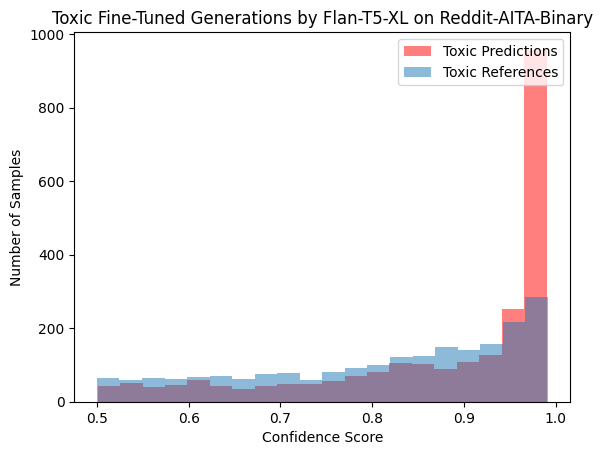

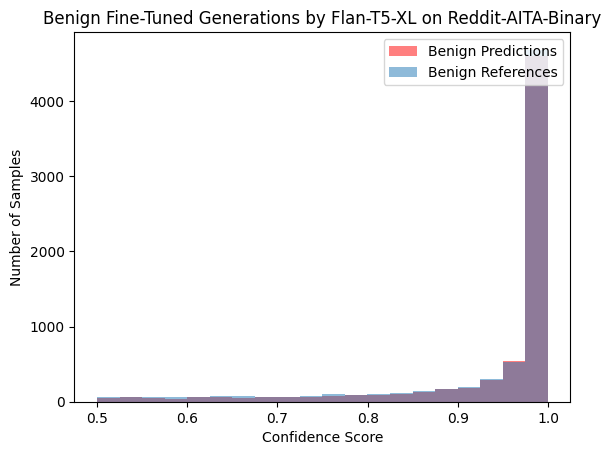

Calculating toxicity for AITA_Finetuned_Evaluations\flan-t5-xl\binary-top-2k\generation_results.json


100%|██████████| 400/400 [00:16<00:00, 23.54it/s]


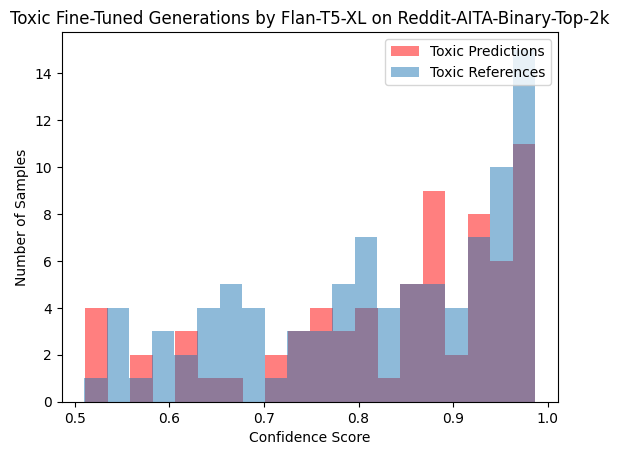

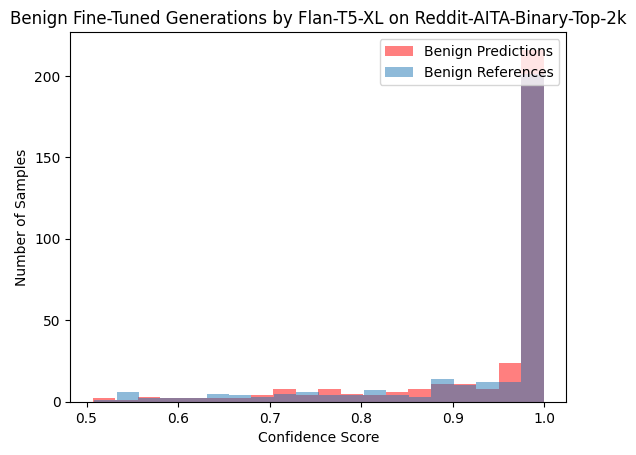

Calculating toxicity for AITA_Finetuned_Evaluations\flan-t5-xl\multiclass\generation_results.json


100%|██████████| 10000/10000 [07:09<00:00, 23.27it/s]


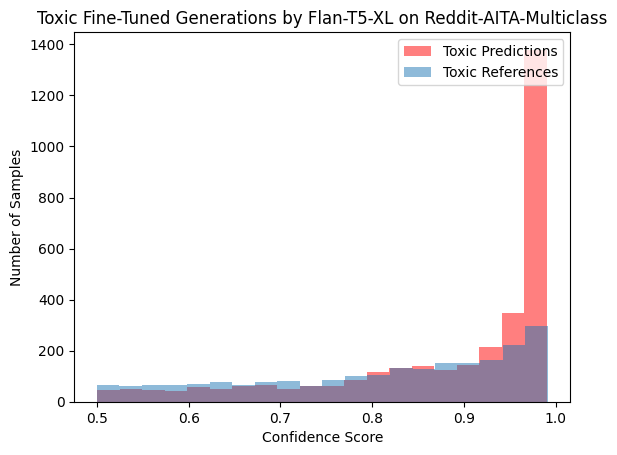

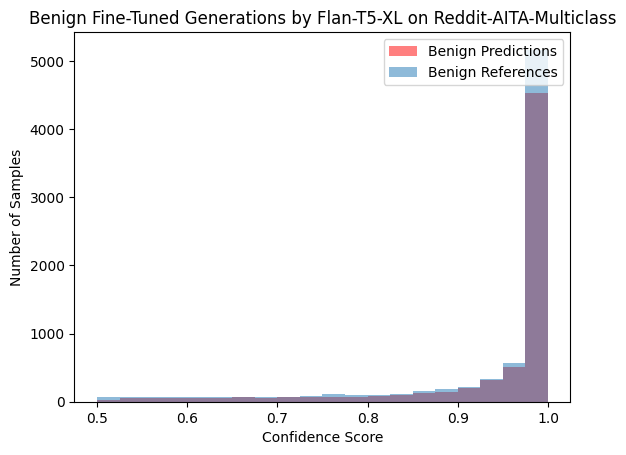

Calculating toxicity for AITA_Finetuned_Evaluations\flan-t5-xl\multiclass-top-2k\generation_results.json


100%|██████████| 400/400 [00:17<00:00, 23.32it/s]


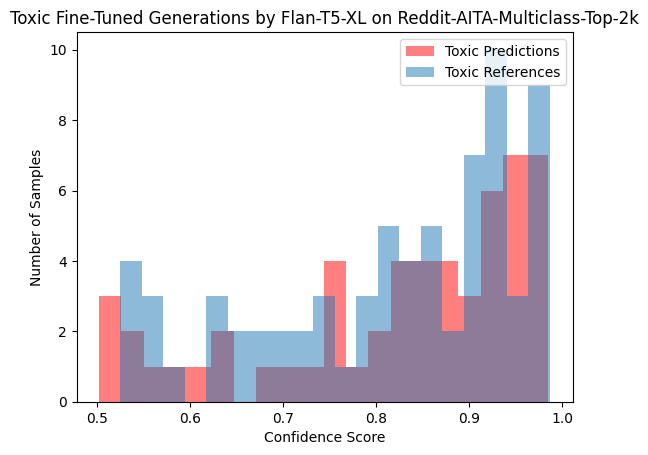

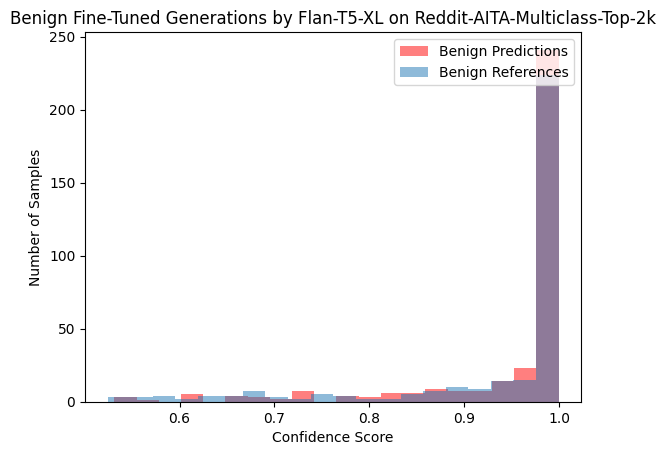

Calculating toxicity for AITA_Finetuned_Evaluations\flan-t5-xxl\binary\generation_results.json


100%|██████████| 9229/9229 [06:33<00:00, 23.43it/s]


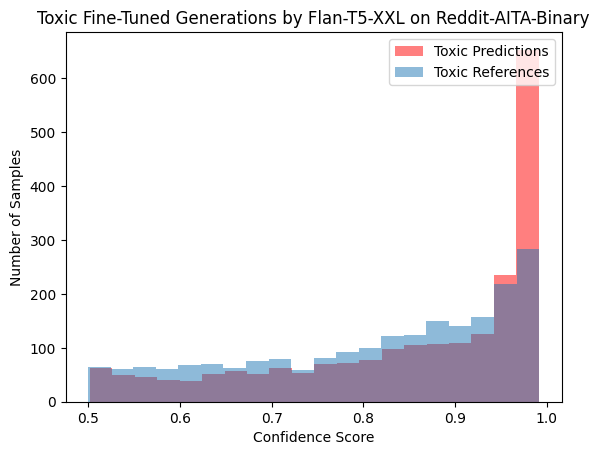

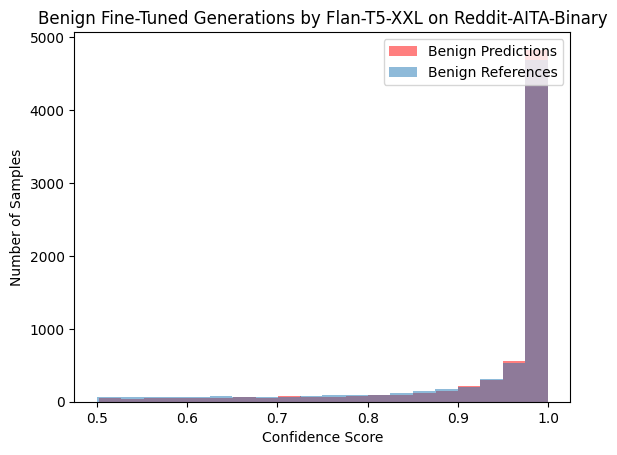

Calculating toxicity for AITA_Finetuned_Evaluations\flan-t5-xxl\binary-top-2k\generation_results.json


100%|██████████| 400/400 [00:16<00:00, 23.70it/s]


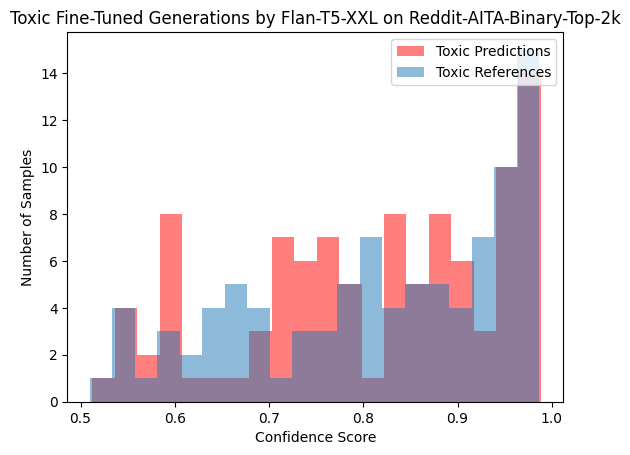

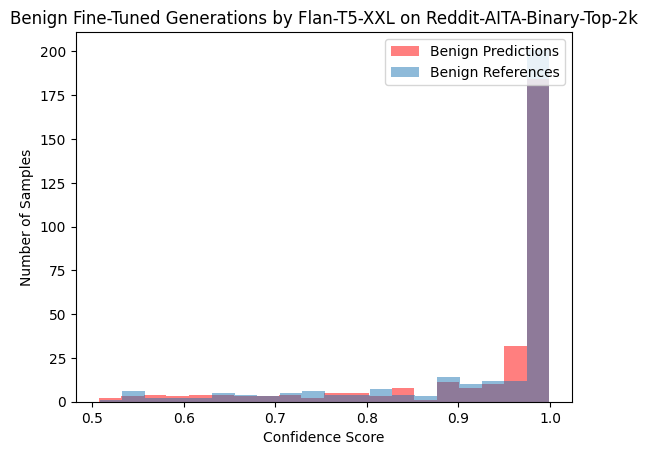

Calculating toxicity for AITA_Finetuned_Evaluations\flan-t5-xxl\multiclass\generation_results.json


100%|██████████| 10000/10000 [07:05<00:00, 23.53it/s]


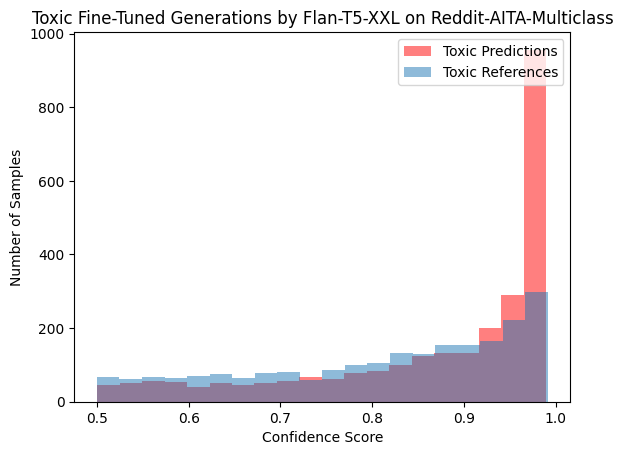

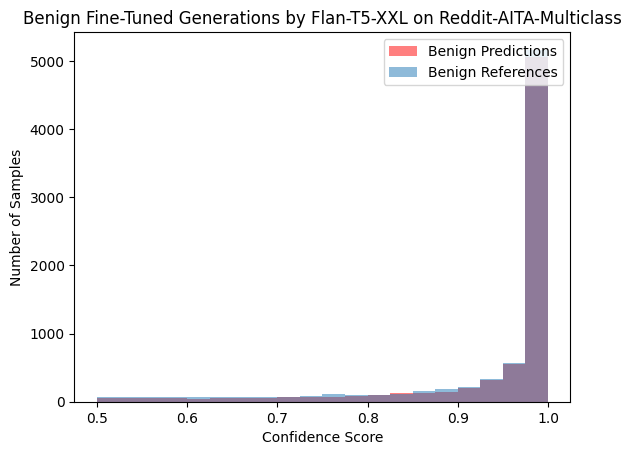

Calculating toxicity for AITA_Finetuned_Evaluations\flan-t5-xxl\multiclass-top-2k\generation_results.json


100%|██████████| 400/400 [00:17<00:00, 23.08it/s]


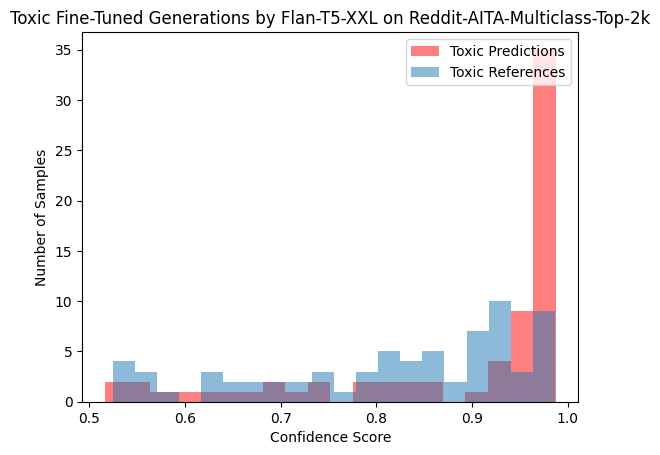

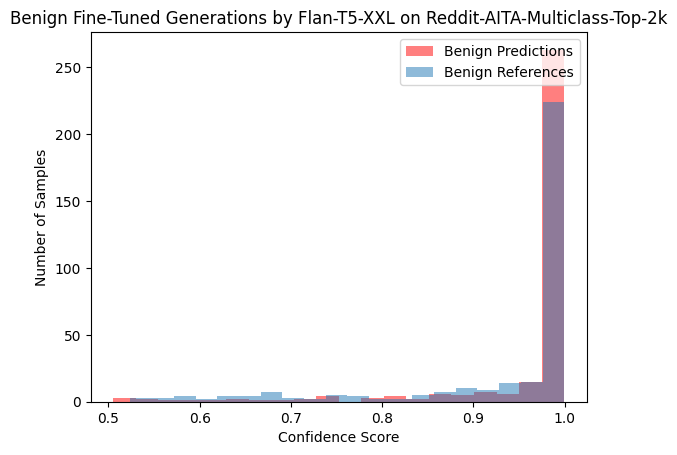

Calculating toxicity for AITA_Finetuned_Evaluations\llama2-7b-chat\binary\generation_results.json


100%|██████████| 9229/9229 [06:44<00:00, 22.84it/s]


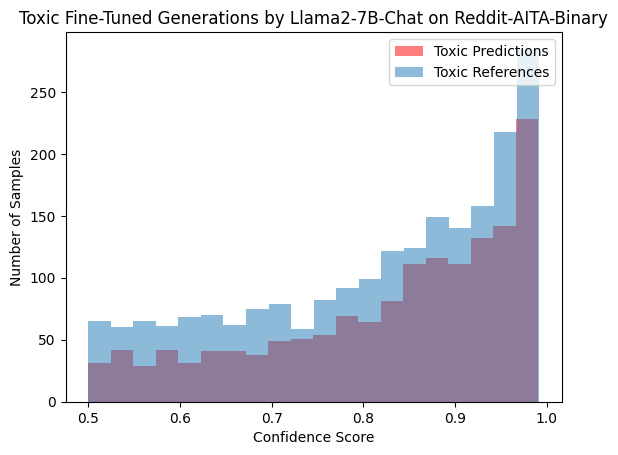

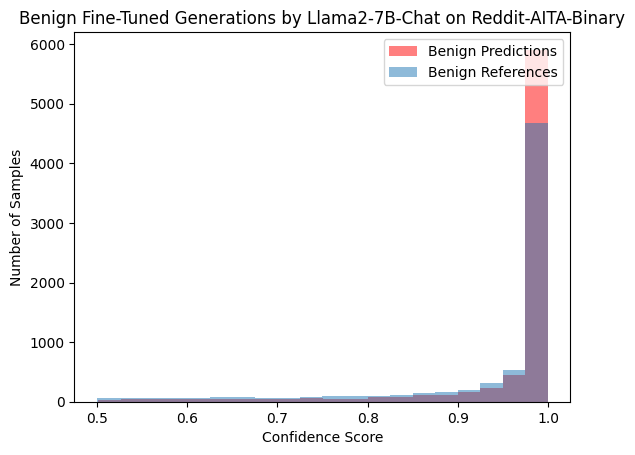

Calculating toxicity for AITA_Finetuned_Evaluations\llama2-7b-chat\binary-top-2k\generation_results.json


100%|██████████| 400/400 [00:17<00:00, 22.47it/s]


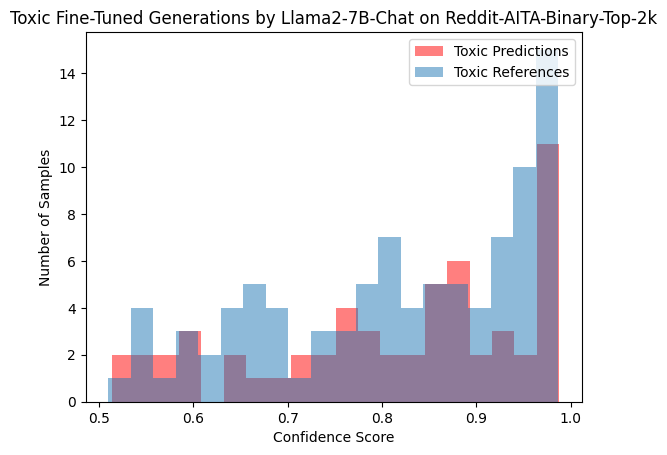

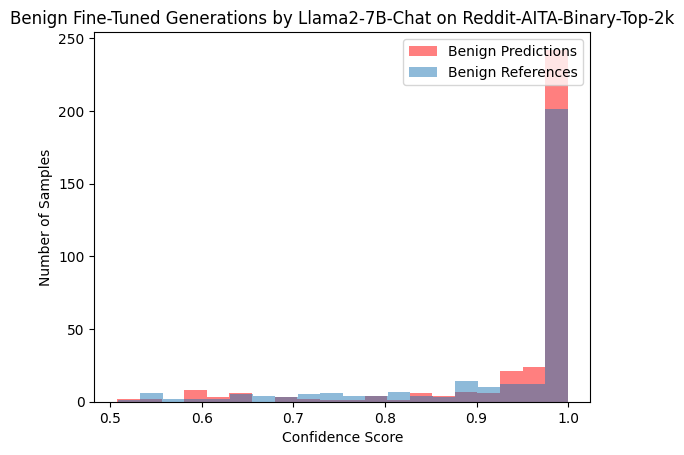

Calculating toxicity for AITA_Finetuned_Evaluations\llama2-7b-chat\multiclass\generation_results.json


100%|██████████| 10000/10000 [07:17<00:00, 22.84it/s]


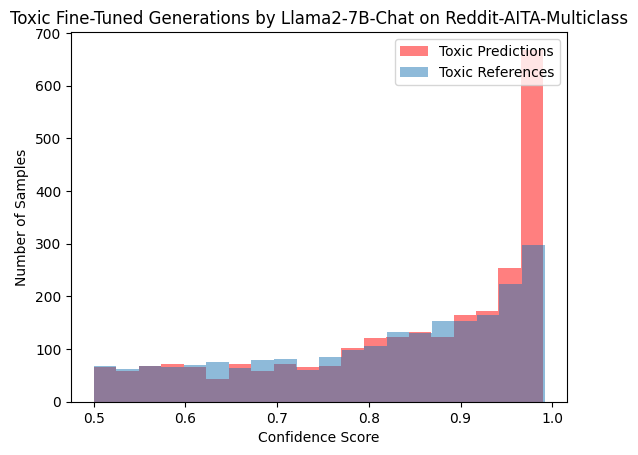

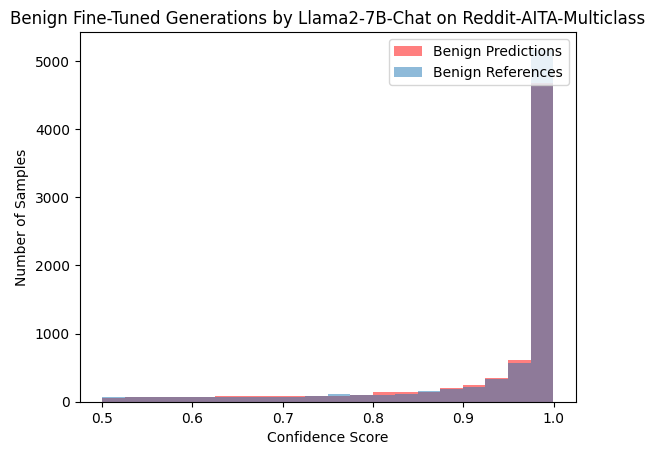

Calculating toxicity for AITA_Finetuned_Evaluations\llama2-7b-chat\multiclass-top-2k\generation_results.json


100%|██████████| 400/400 [00:17<00:00, 22.99it/s]


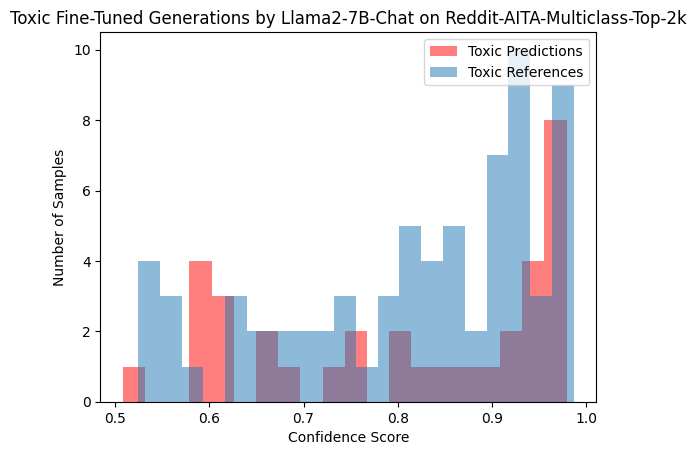

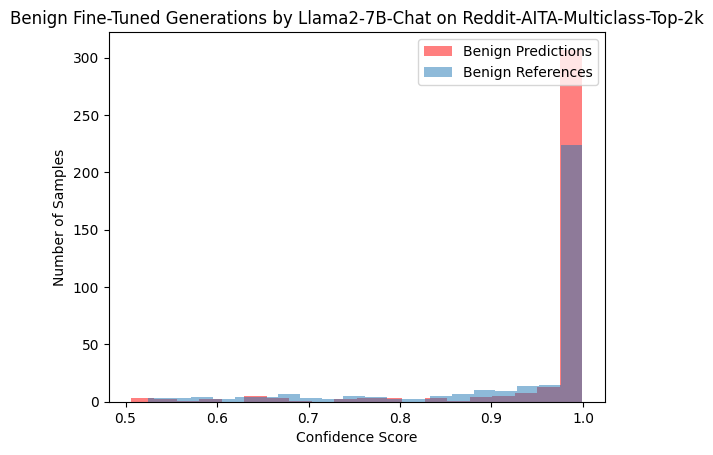

Calculating toxicity for AITA_Finetuned_Evaluations\llama2-13b-chat\binary\generation_results.json


100%|██████████| 9229/9229 [07:06<00:00, 21.62it/s]


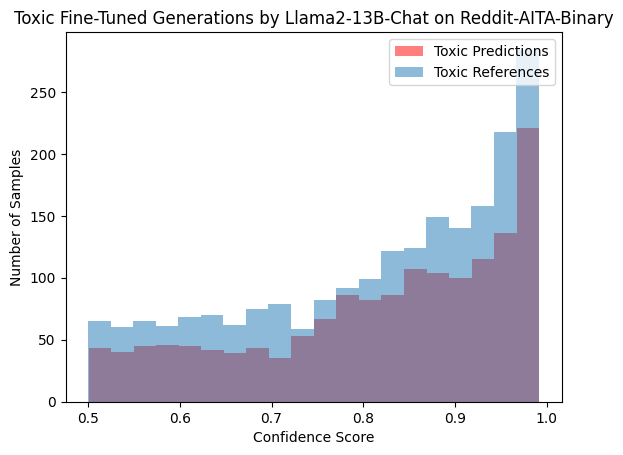

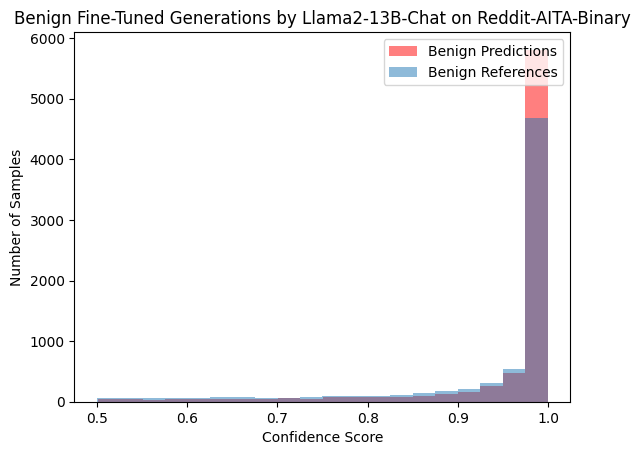

Calculating toxicity for AITA_Finetuned_Evaluations\llama2-13b-chat\binary-top-2k\generation_results.json


100%|██████████| 400/400 [00:18<00:00, 21.28it/s]


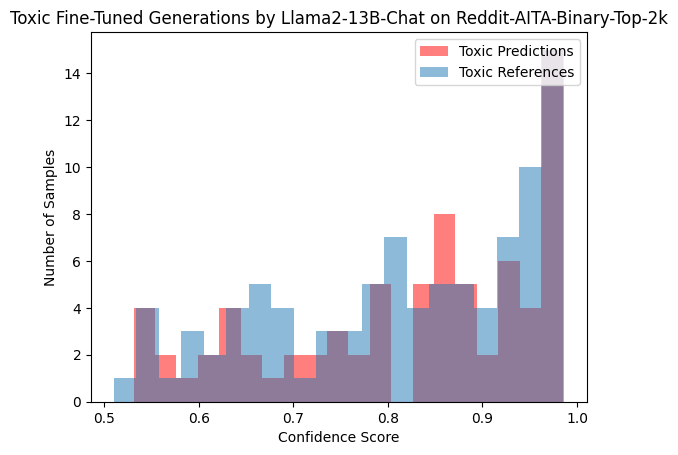

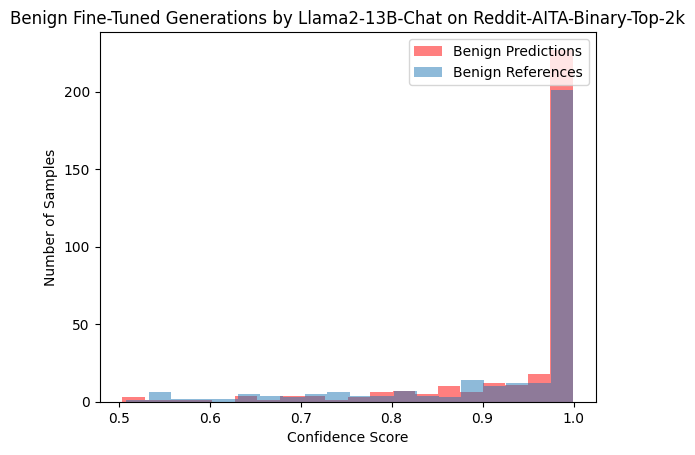

Calculating toxicity for AITA_Finetuned_Evaluations\llama2-13b-chat\multiclass\generation_results.json


100%|██████████| 10000/10000 [07:23<00:00, 22.53it/s]


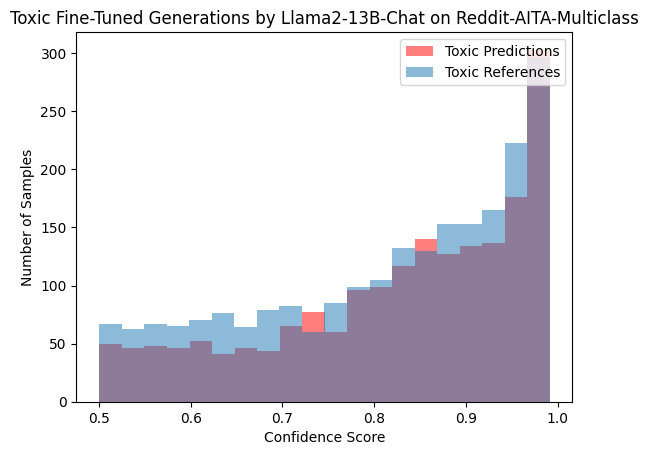

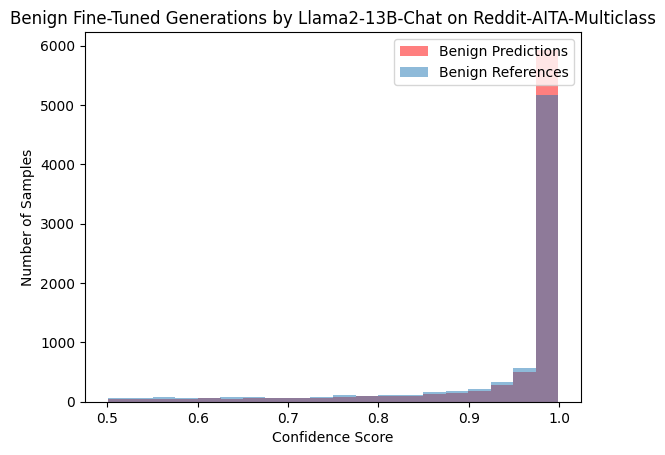

Calculating toxicity for AITA_Finetuned_Evaluations\llama2-13b-chat\multiclass-top-2k\generation_results.json


100%|██████████| 400/400 [00:17<00:00, 23.00it/s]


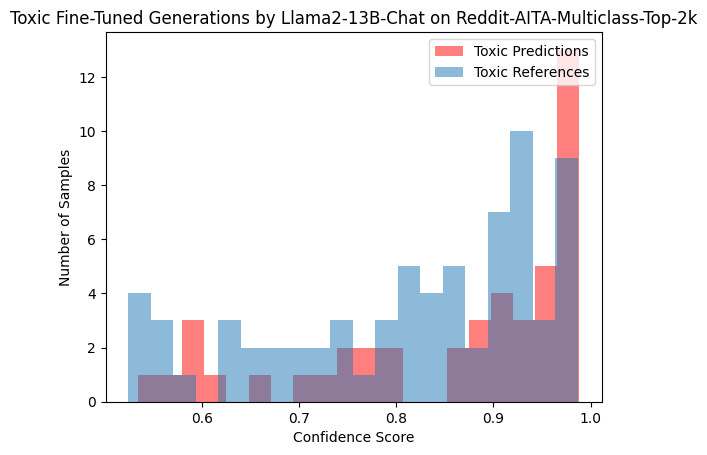

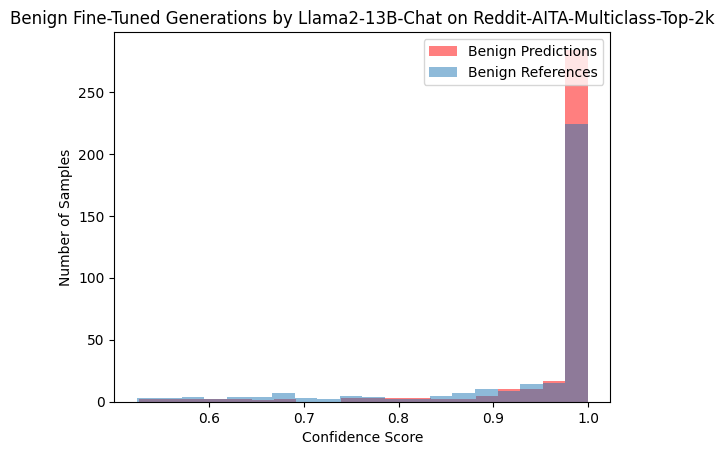

Calculating toxicity for AITA_ZeroShot_Evaluations\flan-t5-xl\binary\generation_results.json


100%|██████████| 9229/9229 [06:23<00:00, 24.06it/s]


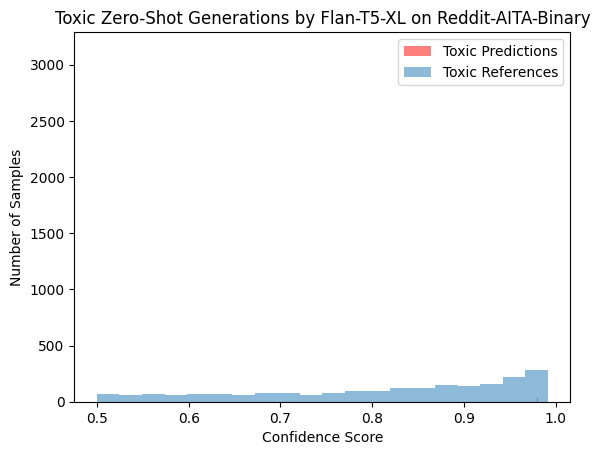

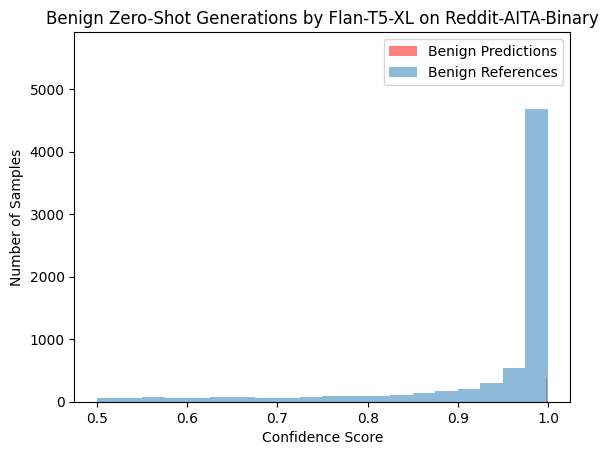

Calculating toxicity for AITA_ZeroShot_Evaluations\flan-t5-xl\binary-top-2k\generation_results.json


100%|██████████| 400/400 [00:16<00:00, 23.61it/s]


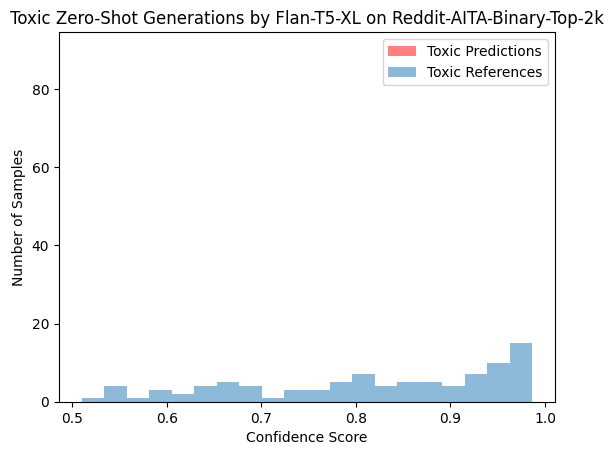

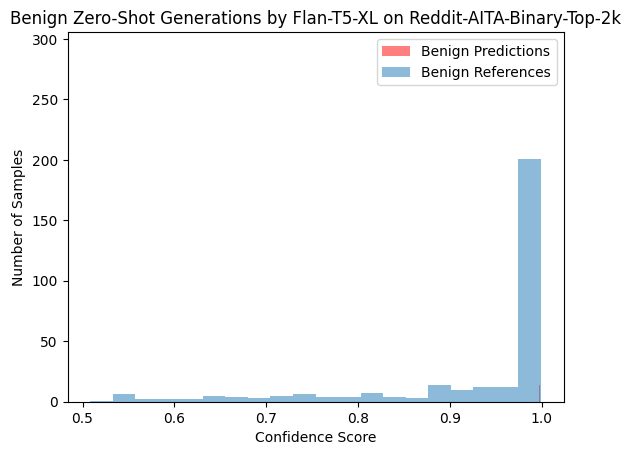

Calculating toxicity for AITA_ZeroShot_Evaluations\flan-t5-xl\multiclass\generation_results.json


100%|██████████| 10000/10000 [07:13<00:00, 23.09it/s]


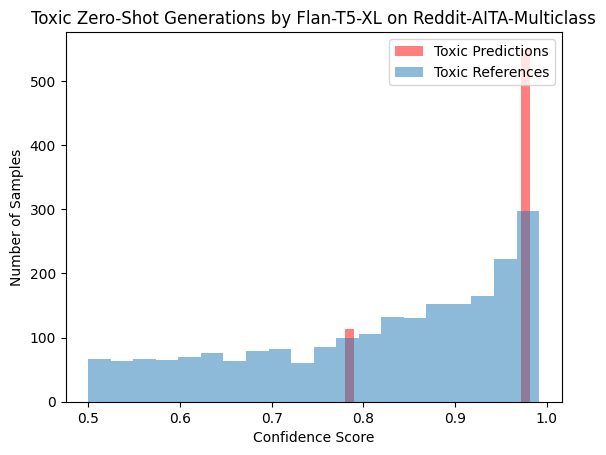

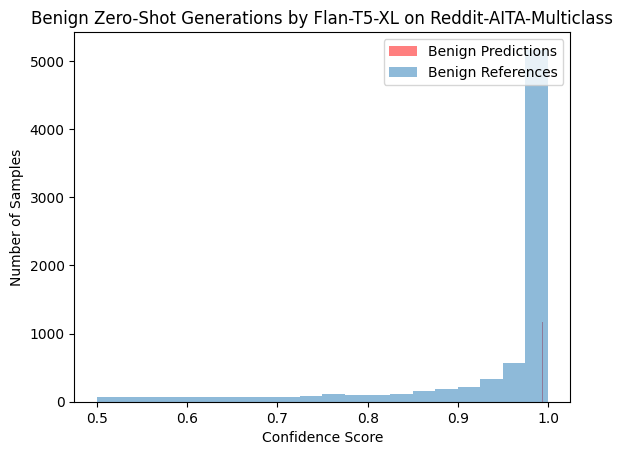

Calculating toxicity for AITA_ZeroShot_Evaluations\flan-t5-xl\multiclass-top-2k\generation_results.json


100%|██████████| 400/400 [00:17<00:00, 22.82it/s]


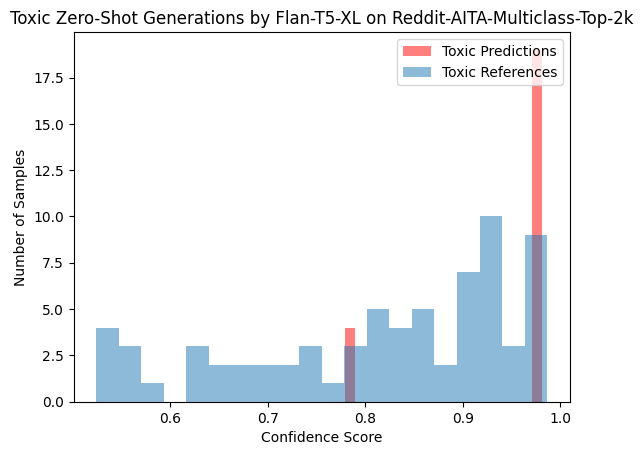

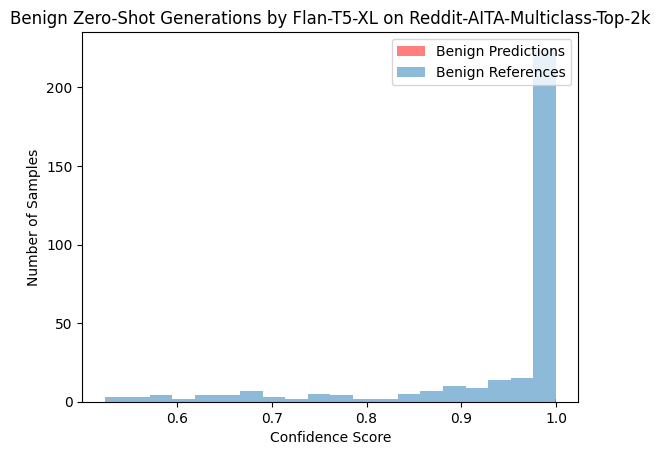

Calculating toxicity for AITA_ZeroShot_Evaluations\flan-t5-xxl\binary\generation_results.json


100%|██████████| 9229/9229 [06:33<00:00, 23.47it/s]


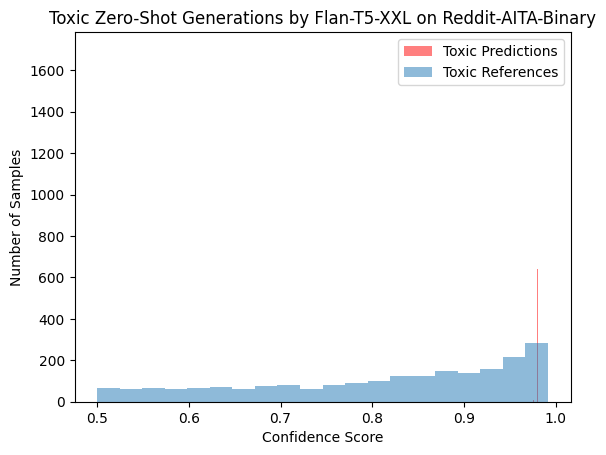

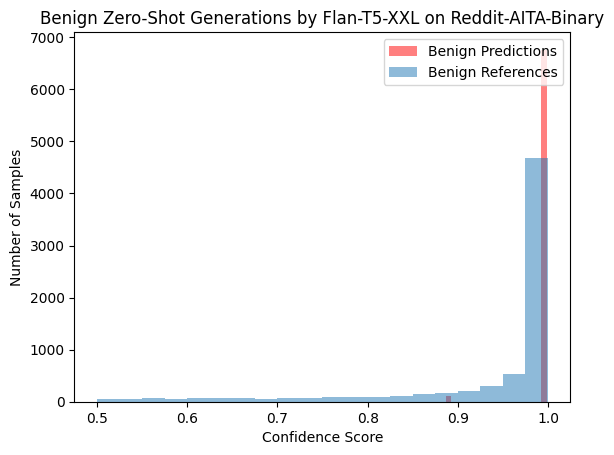

Calculating toxicity for AITA_ZeroShot_Evaluations\flan-t5-xxl\binary-top-2k\generation_results.json


100%|██████████| 400/400 [00:16<00:00, 23.71it/s]


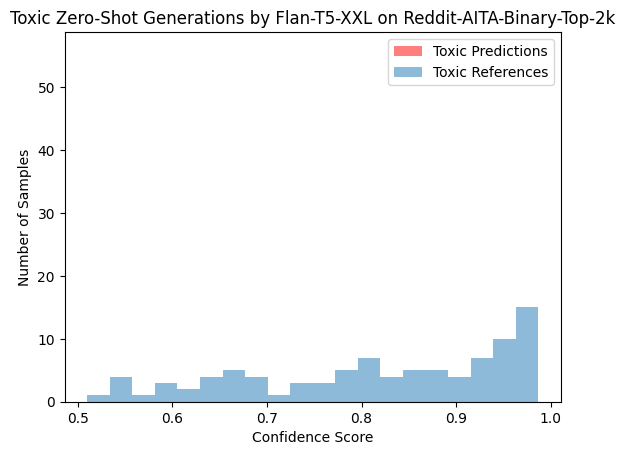

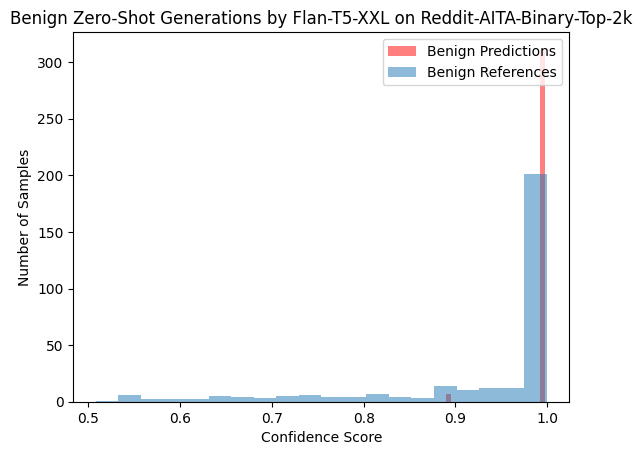

Calculating toxicity for AITA_ZeroShot_Evaluations\flan-t5-xxl\multiclass\generation_results.json


100%|██████████| 10000/10000 [07:03<00:00, 23.62it/s]


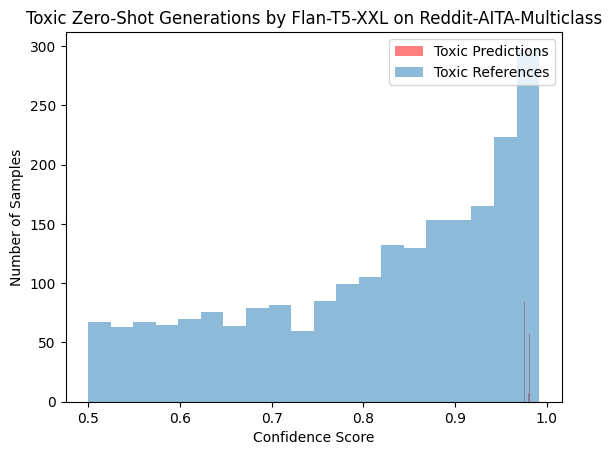

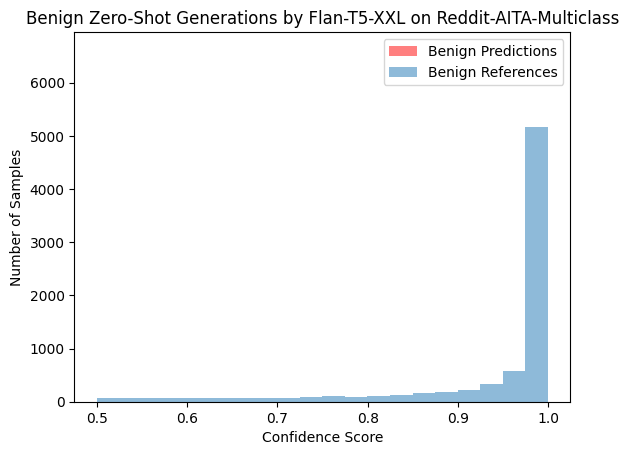

Calculating toxicity for AITA_ZeroShot_Evaluations\flan-t5-xxl\multiclass-top-2k\generation_results.json


100%|██████████| 400/400 [00:16<00:00, 24.53it/s]


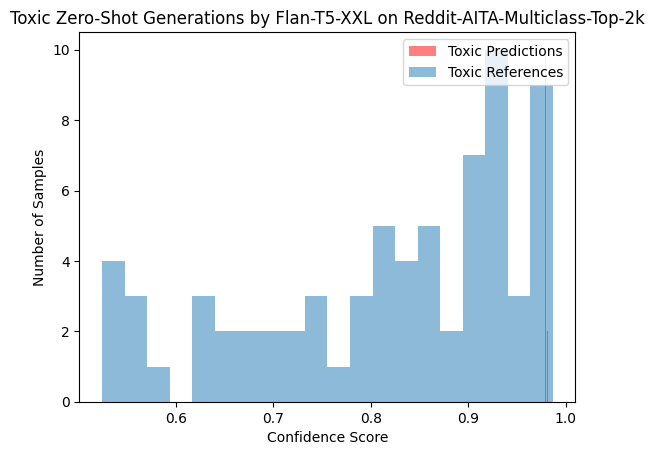

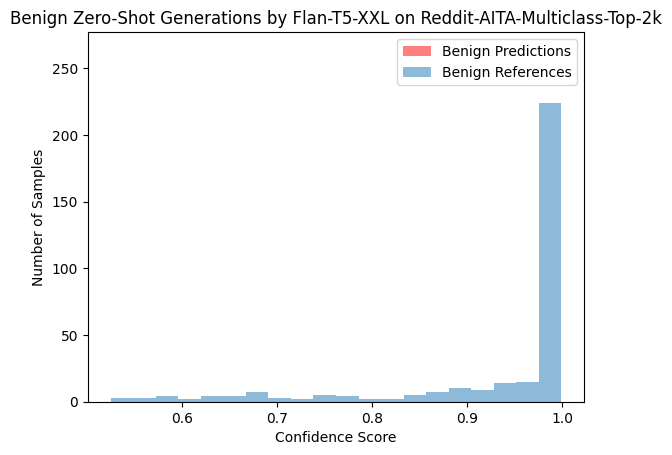

Calculating toxicity for AITA_ZeroShot_Evaluations\llama2-7b-chat\binary\generation_results.json


100%|██████████| 9229/9229 [06:26<00:00, 23.89it/s]


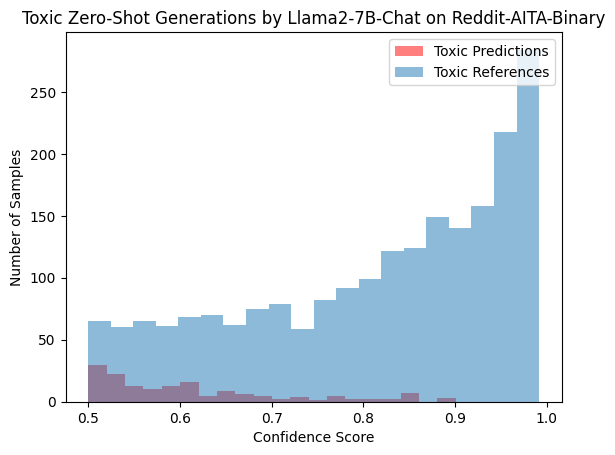

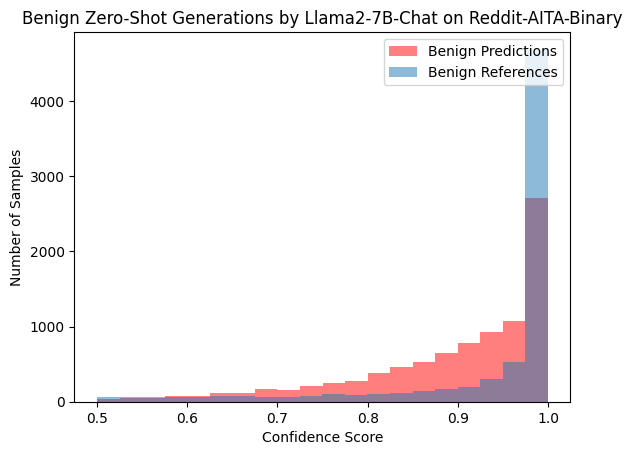

Calculating toxicity for AITA_ZeroShot_Evaluations\llama2-7b-chat\binary-top-2k\generation_results.json


100%|██████████| 400/400 [00:19<00:00, 20.55it/s]


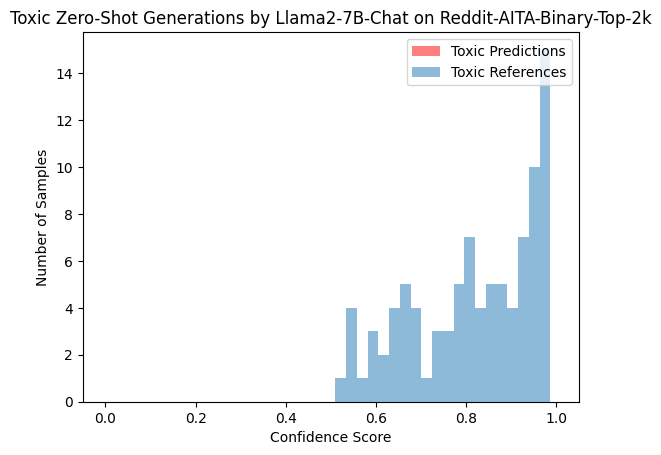

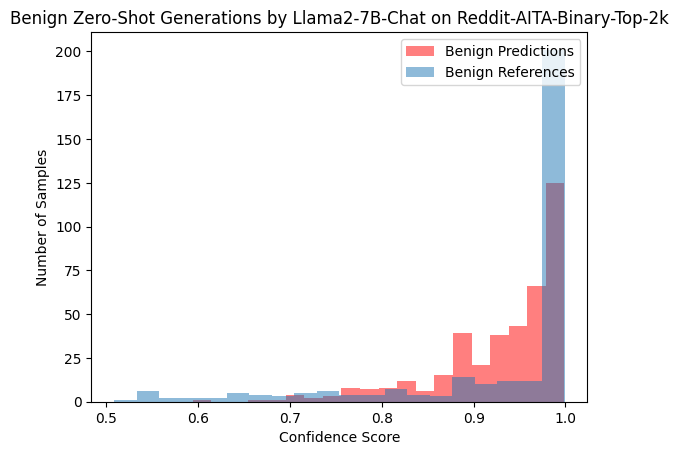

Calculating toxicity for AITA_ZeroShot_Evaluations\llama2-7b-chat\multiclass\generation_results.json


100%|██████████| 10000/10000 [07:47<00:00, 21.39it/s]


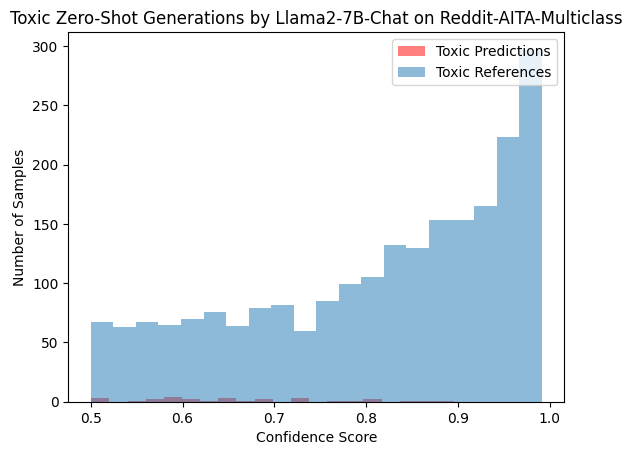

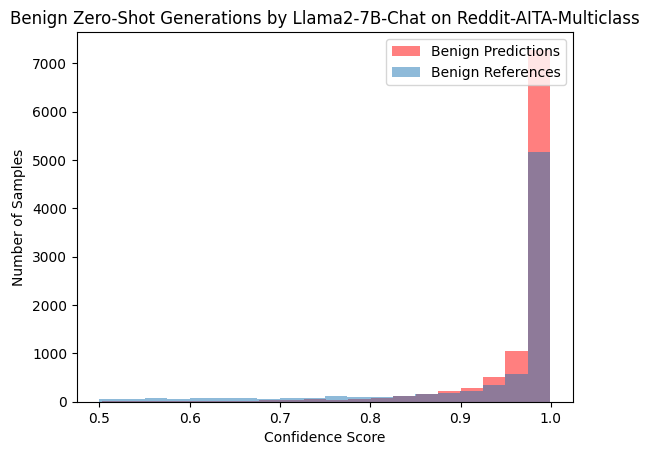

Calculating toxicity for AITA_ZeroShot_Evaluations\llama2-7b-chat\multiclass-top-2k\generation_results.json


100%|██████████| 400/400 [00:18<00:00, 21.70it/s]


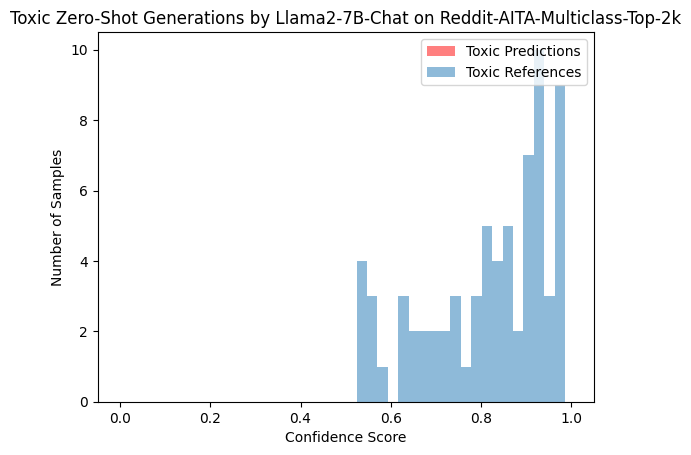

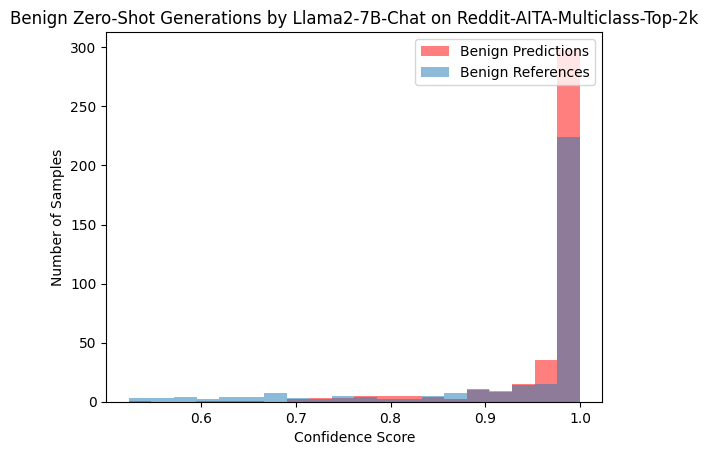

Calculating toxicity for AITA_ZeroShot_Evaluations\llama2-13b-chat\binary\generation_results.json


100%|██████████| 9229/9229 [06:19<00:00, 24.30it/s]


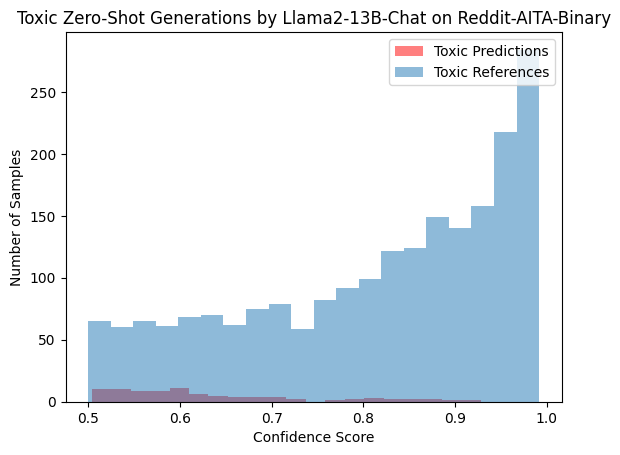

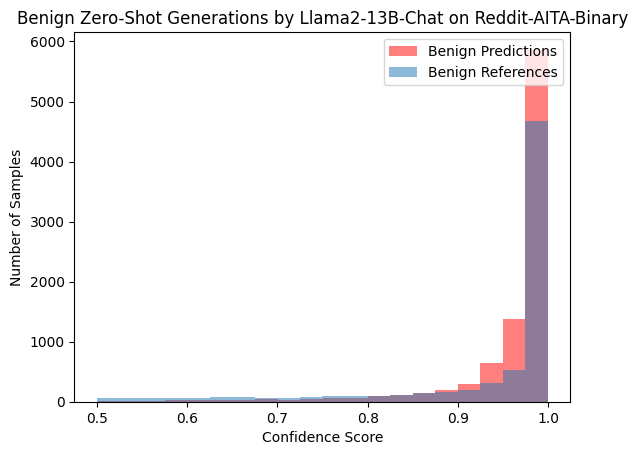

Calculating toxicity for AITA_ZeroShot_Evaluations\llama2-13b-chat\binary-top-2k\generation_results.json


100%|██████████| 400/400 [00:19<00:00, 20.12it/s]


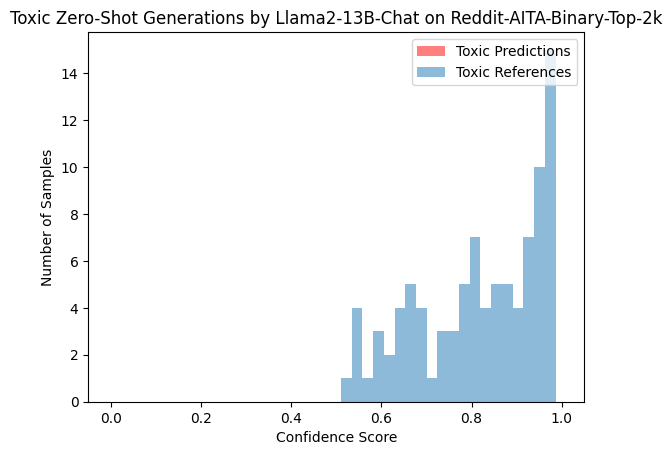

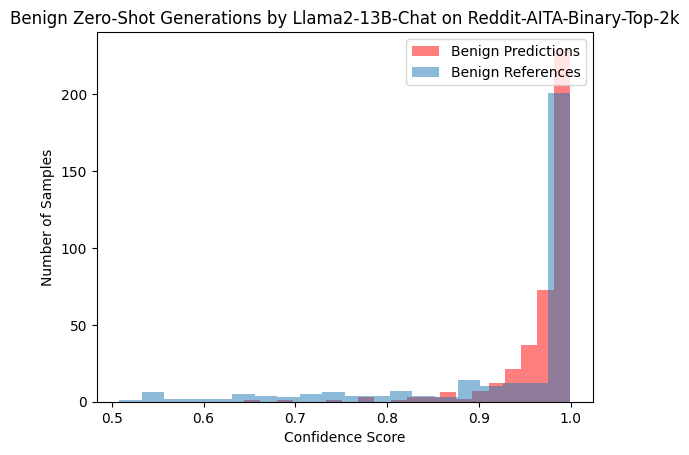

Calculating toxicity for AITA_ZeroShot_Evaluations\llama2-13b-chat\multiclass\generation_results.json


100%|██████████| 10000/10000 [06:54<00:00, 24.13it/s]


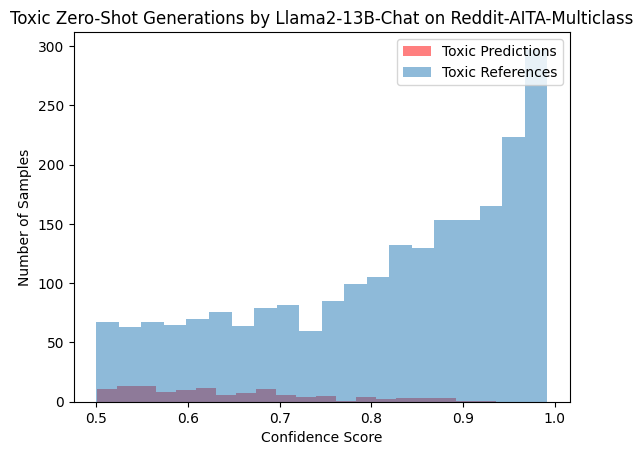

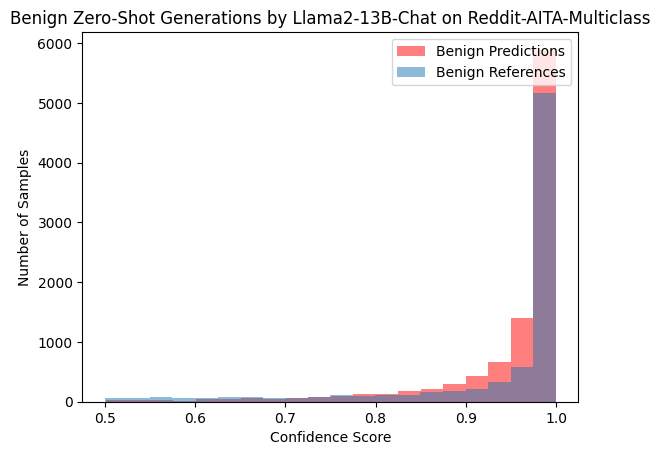

Calculating toxicity for AITA_ZeroShot_Evaluations\llama2-13b-chat\multiclass-top-2k\generation_results.json


100%|██████████| 400/400 [00:20<00:00, 19.83it/s]


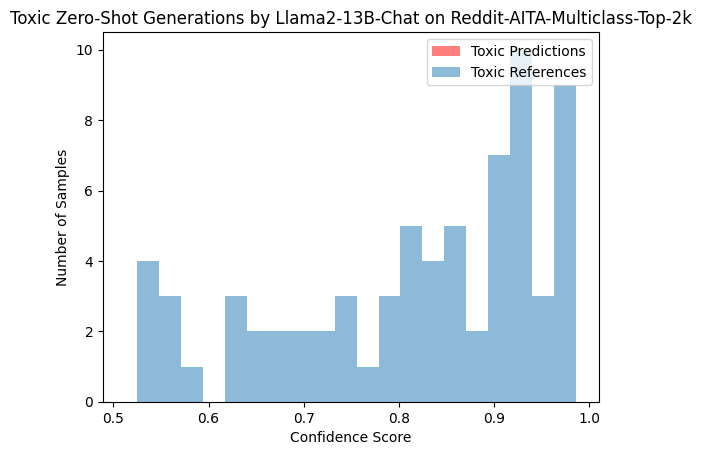

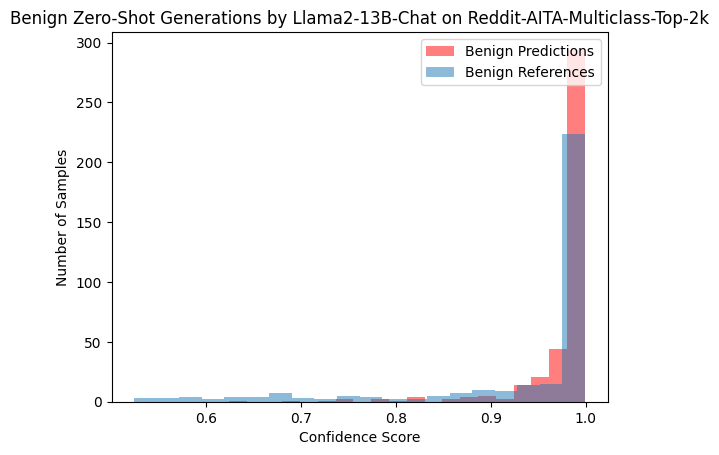

In [41]:
for pair in generation_result_pairs:
    print(f'Calculating toxicity for {pair[0]}')
    generation_results_path = pair[0]
    results_directory = pair[1]

    with open(generation_results_path, 'r') as f:
        generation_results = json.load(f)

    predictions = generation_results['prediction_texts']
    references = generation_results['reference_texts']

    toxicity_scores = {'predictions': [], 'references': []}
    for i in tqdm(range(len(predictions))):
        prediction_toxicity = toxigen_roberta(predictions[i])[0]
        reference_toxicity = toxigen_roberta(references[i])[0]
        toxicity_scores['predictions'].append([prediction_toxicity['label'], prediction_toxicity['score']])
        toxicity_scores['references'].append([reference_toxicity['label'], reference_toxicity['score']])

    # get toxic predictions and references
    toxic_predictions = [score for score in toxicity_scores['predictions'] if score[0] == 'LABEL_1']
    toxic_references = [score for score in toxicity_scores['references'] if score[0] == 'LABEL_1']

    # get nontoxic predictions and references
    non_toxic_predictions = [score for score in toxicity_scores['predictions'] if score[0] == 'LABEL_0']
    non_toxic_references = [score for score in toxicity_scores['references'] if score[0] == 'LABEL_0']

    # get percentages of toxic/non-toxic samples in predictions and references
    percent_toxic_predictions = len(toxic_predictions) / len(predictions)
    percent_toxic_references = len(toxic_references) / len(references)

    toxicity_percentages = {
        'percent_toxic_predictions': percent_toxic_predictions,
        'percent_toxic_references': percent_toxic_references
    }
    toxicity_percentages
    with open(f'{results_directory}\\toxicity_scores.json', 'w') as json_file:
        json.dump(toxicity_percentages, json_file, indent=4)

    # histogram of the toxic prediction and reference scores 
    prediction_toxic_scores = [score[1] for score in toxic_predictions]
    reference_toxic_scores = [score[1] for score in toxic_references]

    if re.search(r'ZeroShot', pair[0]):
        toxic_title = f'Toxic Zero-Shot Generations by {pair[2]} on {pair[3]}'
        benign_title = f'Benign Zero-Shot Generations by {pair[2]} on {pair[3]}'
    else:
        toxic_title = f'Toxic Fine-Tuned Generations by {pair[2]} on {pair[3]}'
        benign_title = f'Benign Fine-Tuned Generations by {pair[2]} on {pair[3]}'

    plt.hist(prediction_toxic_scores, bins=20, alpha=0.5, label='Toxic Predictions', color='red')
    plt.hist(reference_toxic_scores, bins=20, alpha=0.5, label='Toxic References')
    plt.legend(loc='upper right')
    plt.title(toxic_title)
    plt.xlabel('Confidence Score')
    plt.ylabel('Number of Samples')
    plt.savefig(f'{results_directory}\\toxic_responses.png')
    plt.show()

    # histogram of the non-toxic prediction reference scores
    prediction_non_toxic_scores = [score[1] for score in non_toxic_predictions]
    reference_non_toxic_scores = [score[1] for score in non_toxic_references]

    plt.hist(prediction_non_toxic_scores, bins=20, alpha=0.5, label='Benign Predictions', color='red')
    plt.hist(reference_non_toxic_scores, bins=20, alpha=0.5, label='Benign References')
    plt.legend(loc='upper right')
    plt.title(benign_title)
    plt.xlabel('Confidence Score')
    plt.ylabel('Number of Samples')
    plt.savefig(f'{results_directory}\\benign_responses.png')
    plt.show()